**import Libraries**

---



In [ ]:
# Visualization Libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing Libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

# ML Libraries
from sklearn.ensemble import RandomForestClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsRegressor

# Evaluation Metrics
from yellowbrick.classifier import ClassificationReport
from sklearn import metrics

# **model prediction**

# pre-prosses data Classification

In [ ]:
da = pd.read_csv('/content/drive/MyDrive/Crimes_-_2001_to_Present.csv')

In [ ]:
da = da.dropna() #حذف القيم الفارغه
da = da.sample(n=1000000) # اخذ جزء من البيانات
df = da # نسخ البيانات في متغير جديد
# تحويل التاريخ صيغة التاريخ
df['date2'] = pd.to_datetime(df['Date'])
df['Year'] = df['date2'].dt.year
df['Month'] = df['date2'].dt.month
df['Day'] = df['date2'].dt.day
df['Hour'] = df['date2'].dt.hour
df['Minute'] = df['date2'].dt.minute
df['Second'] = df['date2'].dt.second

# حذف الأعمدة الغير مفيدة
df = df.drop(['Date'], axis=1)
df = df.drop(['date2'], axis=1)
df = df.drop(['Updated On'], axis=1)
df = df.drop(['ID'], axis=1)
df = df.drop(['Case Number'], axis=1)

crime_counts = df.groupby('Primary Type').size()

num_crime = len(df['Primary Type'].unique())

crime_level = crime_counts / num_crime

def set_safety_level(rate):
    if rate < 150:
        return "very_low"
    if rate < 600:
        return "low"
    if rate < 1500:
        return "mid"
    elif rate < 2000:
        return "high"
    else:
        return "very_high"

df['crime_level'] = df['Primary Type'].map(crime_level).apply(set_safety_level)


# تحويل القيم من نصية إلى رقمية
df['crime_level'] = pd.factorize(df["crime_level"])[0]
df['Block'] = pd.factorize(df["Block"])[0]
df['IUCR'] = pd.factorize(df["IUCR"])[0]
df['Description'] = pd.factorize(df["Description"])[0]
df['Location Description'] = pd.factorize(df["Location Description"])[0]
df['FBI Code'] = pd.factorize(df["FBI Code"])[0]
df['Location'] = pd.factorize(df["Location"])[0]

# إنشاء متغير لتخزين به الهدف في التنبؤ
Target = 'Primary Type'
print('Target: ', Target)


Target:  Primary Type


In [ ]:
# تجميع البيانات وتخزينها في عمود في جدول بياني
all_classes = df.groupby(['Primary Type'])['Block'].size().reset_index()
all_classes['Amt'] = all_classes['Block']
all_classes = all_classes.drop(['Block'], axis=1)
all_classes = all_classes.sort_values(['Amt'], ascending=[False])

# تخزين اقل ١٣ جريمه ليتم تحويلها لإسم اخر
unwanted_classes = all_classes.tail(13)

df.loc[df['Primary Type'].isin(unwanted_classes['Primary Type']), 'Primary Type'] = 'OTHERS'

# Plot Bar Chart visualize Primary Types
plt.figure(figsize=(14,10))
plt.title('Amount of Crimes by Primary Type')
plt.ylabel('Crime Type')
plt.xlabel('Amount of Crimes')

df.groupby([df['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')

plt.show()

<ipython-input-296-2ba3f4e4e0c0>:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


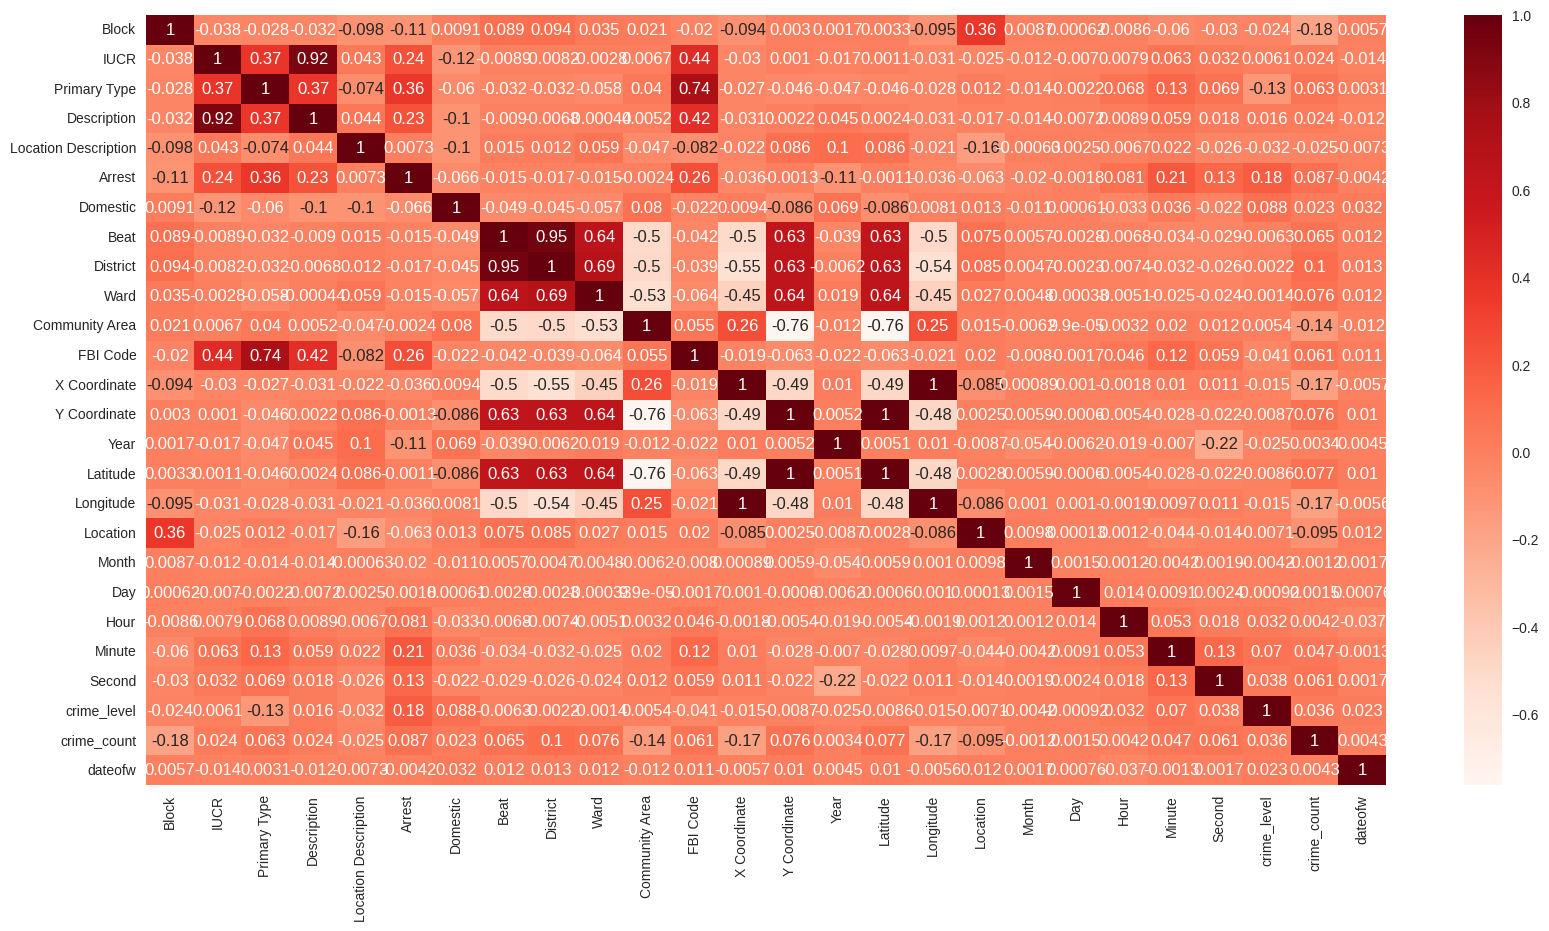

In [296]:
# تخزين القيم الفريدة في متغير
Classes = df['Primary Type'].unique()
Classes

# تحويل القيم النصية الى رقمية
df['Primary Type'] = pd.factorize(df["Primary Type"])[0]
#df['Primary Type'].unique()
#X_fs = df.drop(['Primary Type'], axis=1)
#Y_fs = df['Primary Type']

#Using Pearson Correlation
plt.figure(figsize=(20,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
df['Community Area'] = df['Community Area'].astype(int)

In [318]:

Features = ["FBI Code","crime_level","Community Area","Year","Month","Day"]
print('Full Features: ', Features)

x, y = train_test_split(df,
                        test_size = 0.2,
                        train_size = 0.8,
                        random_state= 3)

x1 = x[Features]    #Features to train
x2 = x[Target]      #Target Class to train
y1 = y[Features]    #Features to test
y2 = y[Target]      #Target Class to test

print('Feature Set Used    : ', Features)
print('Target Class        : ', Target)
print('Training Set Size   : ', x.shape)
print('Test Set Size       : ', y.shape)

Full Features:  ['FBI Code', 'crime_level', 'Community Area', 'Year', 'Month', 'Day']
Feature Set Used    :  ['FBI Code', 'crime_level', 'Community Area', 'Year', 'Month', 'Day']
Target Class        :  Primary Type
Training Set Size   :  (800000, 27)
Test Set Size       :  (200000, 27)


# **RandomForestClassifier**

In [319]:
rf_model = RandomForestClassifier(n_estimators=70, # Number of trees
                                  min_samples_split = 30,
                                  bootstrap = True,
                                  max_depth = 50,
                                  min_samples_leaf = 25)

# Model Training
rf_model.fit(X=x1,
             y=x2)

# Prediction
result = rf_model.predict(y[Features])

In [320]:
ac_sc = accuracy_score(y2, result)
rc_sc = recall_score(y2, result, average="weighted")
pr_sc = precision_score(y2, result, average="weighted")
f1_sc = f1_score(y2, result, average='micro')
confusion_m = confusion_matrix(y2, result)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
#print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.99536
Recall      :  0.99536
Precision   :  0.9954457321735831
F1 Score    :  0.99536
Confusion Matrix: 


In [398]:
classCheck= [13,1,3,2003,9,19]
classP = np.array(classCheck).reshape(1,-1)
rf_model.predict(classP)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([6])

In [345]:
import pickle

with open('classificationMrand_model.pkl', 'wb') as pkl:
    pickle.dump(rf_model, pkl)

# **KNN Classification**

In [346]:
knnC_model = KNeighborsClassifier(k=3)
knnC_model.fit(x1, x2)
knPre = knnC_model.predict(y[Features])

In [347]:
ac_sc = accuracy_score(y2, knPre)
rc_sc = recall_score(y2, knPre, average="weighted")
pr_sc = precision_score(y2, knPre, average="weighted")
f1_sc = f1_score(y2, knPre, average='micro')
confusion_m = confusion_matrix(y2, knPre)

print("========== Random Forest Results ==========")
print("Accuracy    : ", ac_sc)
print("Recall      : ", rc_sc)
print("Precision   : ", pr_sc)
print("F1 Score    : ", f1_sc)
print("Confusion Matrix: ")
#print(confusion_m)

========== Random Forest Results ==========
Accuracy    :  0.845605
Recall      :  0.845605
Precision   :  0.841304217024543
F1 Score    :  0.845605
Confusion Matrix: 


In [390]:
y2

4963246     4
3954838     2
7690853     6
2270856    15
4271855     4
           ..
3843393     0
2573324    14
2626964     6
6559075     2
879246      2
Name: Primary Type, Length: 200000, dtype: int64

In [391]:
y[Features].head()

,FBI Code,crime_level,Community Area,Year,Month,Day
4963246,4,2,67,2009,7,5
3954838,2,2,46,2007,4,12
7690853,6,1,17,2022,11,28
2270856,13,0,3,2003,9,19
4271855,4,2,2,2008,2,8


In [397]:
classCheckk= [3,2,46,2007,4,1]
classPk = np.array(classCheckk).reshape(1,-1)
knnC_model.predict(classPk)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([3])

In [ ]:
import pickle

with open('knn_model.pkl', 'wb') as pkl:
    pickle.dump(knn_model, pkl)

# pre-prosess data regression

In [ ]:
dfR=df

crime_counts = da.groupby(['Community Area'])['Primary Type'].size()
num1_crime = len(df['Community Area'].unique())

crime_level = crime_counts / num1_crime / 31

dfR['crime_count'] = dfR['Community Area'].map(crime_level)
dfR['crime_count'] = dfR.crime_count.astype(int)
dfR['crime_count'].head(15)

In [ ]:
dfR['Community Area']=dfR['Community Area'].astype(int)
dfR['District']=dfR['District'].astype(int)

In [ ]:
Features1 = ["FBI Code","crime_level",'District',"Community Area","Year","Month","Day"]
print('Full Features: ', Features1)
Target1 = ["crime_count"]

Full Features:  ['FBI Code', 'crime_level', 'District', 'Community Area', 'Year', 'Month', 'Day']


In [ ]:
xr, yr = train_test_split(dfR,
                        test_size = 0.2,
                        train_size = 0.8,
                        random_state= 3)

x1r = xr[Features1]    #Features to train
x2r = xr[Target1]      #Target Class to train
y1r = yr[Features1]    #Features to test
y2r = yr[Target1]      #Target Class to test

print('Feature Set Used    : ', Features1)
print('Target Class        : ', Target1)
print('Training Set Size   : ', xr.shape)
print('Test Set Size       : ', yr.shape)

Feature Set Used    :  ['FBI Code', 'crime_level', 'District', 'Community Area', 'Year', 'Month', 'Day']
Target Class        :  ['crime_count']
Training Set Size   :  (800000, 25)
Test Set Size       :  (200000, 25)


# **DecisionTreeRegressor**

In [ ]:
from sklearn.tree import DecisionTreeRegressor
rModell = DecisionTreeRegressor(min_samples_split = 30,
                                  max_depth = 50,
                                  min_samples_leaf = 25)
rModell.fit(x1r, x2r)
pred_der = rModell.predict(yr[Features1])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

print("Mean Squared Error = ", mean_squared_error(yr[Target1], pred_der))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(yr[Target1], pred_der)))
print("R2 Score = ", r2_score(yr[Target1], pred_der))

Mean Squared Error =  0.004835756762507585
Root Mean Squared Error =  0.06953960571147628
R2 Score =  0.9998596246786211


In [ ]:
yr[Features1].head(1)

,FBI Code,crime_level,District,Community Area,Year,Month,Day
3985212,2,0,3,42,2007,5,14


In [450]:
rr = [1,2,3,4,2025,6,7]
br = np.array(rr).reshape(1,-1)
rModell.predict(br)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([2.])

# **KNeighborsRegressor**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(x1r, x2r)
pred_kr = knn_model.predict(yr[Features1])
print("Mean Squared Error = ", mean_squared_error(yr[Target1], pred_kr))
print("Root Mean Squared Error = ", np.sqrt(mean_squared_error(yr[Target1], pred_kr)))
print("R2 Score = ", r2_score(yr[Target1], pred_kr))

Mean Squared Error =  3.6057462
Root Mean Squared Error =  1.8988802489888614
R2 Score =  0.895330181708055


In [457]:
rx = [0,0,0,0,2025,0,0]
bx = np.array(rx).reshape(1,-1)
knn_model.predict(bx)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


array([[1.6]])

In [ ]:
import pickle

with open('knn_model.pkl', 'wb') as pkl:
    pickle.dump(knn_model, pkl)
